In [ ]:
import matplotlib.pyplot as plt
import sys

def plot_ipc_from_file(filepath):
    """
    Reads a file where each line is a float representing IPC,
    and generates a plot of IPC over time.

    Args:
        filepath (str): The path to the input data file.
    """
    ipc_values = []
    try:
        with open(filepath, 'r') as f:
            for line_num, line in enumerate(f, 1):
                # Strip whitespace and check if the line is empty
                cleaned_line = line.strip()
                if not cleaned_line:
                    continue

                # Try to convert the line to a float
                try:
                    ipc_values.append(float(cleaned_line))
                except ValueError:
                    print(f"Warning: Could not parse line {line_num}: '{line.strip()}'. Skipping.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        sys.exit(1) # Exit the script if the file doesn't exist

    if not ipc_values:
        print("Error: No valid data points were found in the file.")
        sys.exit(1)

    # The data is recorded every 0.5 seconds.
    # We create a corresponding time axis.
    time_axis = [i * 0.5 for i in range(len(ipc_values))]

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(time_axis, ipc_values, marker='o', linestyle='-', markersize=4, label='IPC')

    # Set titles and labels for clarity
    ax.set_title('Instructions Per Cycle (IPC) Over Time', fontsize=16)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Instructions Per Cycle (IPC)', fontsize=12)

    # Add a legend
    ax.legend()

    # Improve layout and display the plot
    plt.tight_layout()
    plt.show()


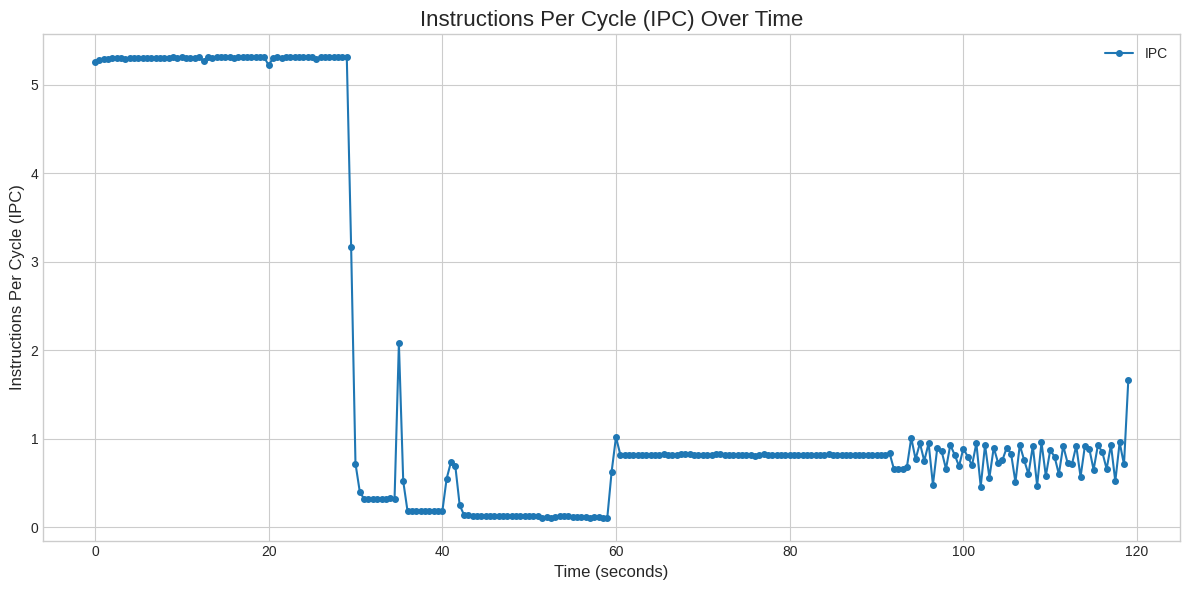

In [ ]:
data_file = 'ipc_stat_val'
plot_ipc_from_file(data_file)


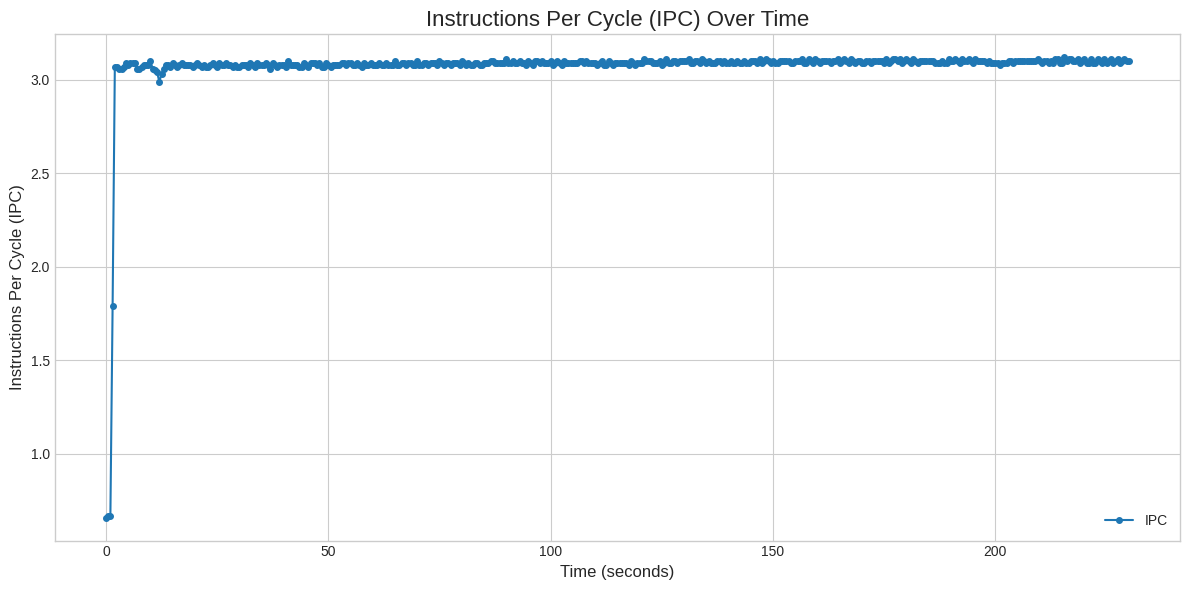

In [ ]:
data_file = 'ipc_stat_ldu_val'
plot_ipc_from_file(data_file)

In [ ]:
import matplotlib.pyplot as plt
import sys
import numpy as np

# --- Assumed Penalties (in cycles) ---
# NOTE: These are typical, estimated values. For an accurate CPI stack, these
# should be replaced with values specific to the target CPU architecture.
BRANCH_MISS_PENALTY = 20
CACHE_MISS_PENALTY = 100  # Assuming this is for an L2 cache miss
L1_DTLB_MISS_PENALTY = 30
L2_DTLB_MISS_PENALTY = 80
L2_ITLB_MISS_PENALTY = 80

def plot_cpi_stack_from_file(filepath):
    """
    Reads performance counter data from a file, calculates CPI components based on
    assumed penalties, and generates a stacked area plot of the CPI stack over time.

    The file is expected to contain repeating blocks of 7 lines:
    <count> instructions
    <count> cycles
    <count> branch-misses
    ... and so on.

    Args:
        filepath (str): The path to the input data file.
    """
    data_points = []
    expected_metrics = [
        'instructions', 'cycles', 'branch-misses', 'cache-misses',
        'l1_dtlb_misses', 'l2_dtlb_misses', 'l2_itlb_misses'
    ]

    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

            # Process the file in chunks of 7 lines
            for i in range(0, len(lines), 7):
                chunk = lines[i:i+7]
                if len(chunk) < 7:
                    print(f"Warning: Incomplete data block at the end of the file. Skipping.")
                    continue

                point = {}
                valid_chunk = True
                for j, line in enumerate(chunk):
                    parts = line.strip().split()
                    if len(parts) >= 2 and parts[1] == expected_metrics[j]:
                        point[parts[1]] = int(parts[0])
                    else:
                        print(f"Warning: Malformed or unexpected line {i+j+1}: '{line.strip()}'. Skipping this data block.")
                        valid_chunk = False
                        break

                if valid_chunk:
                    data_points.append(point)

    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        sys.exit(1)
    except (ValueError, IndexError) as e:
        print(f"Error processing file: {e}. Please check the file format.")
        sys.exit(1)

    if not data_points:
        print("Error: No valid data points were found in the file.")
        sys.exit(1)

    # --- CPI Calculation ---
    base_cpis, branch_cpis, cache_cpis, l1_dtlb_cpis, l2_dtlb_cpis, l2_itlb_cpis = [], [], [], [], [], []

    for point in data_points:
        instr = point['instructions']
        if instr == 0: continue # Avoid division by zero

        # Calculate CPI contribution for each penalty
        cpi_branch = (point['branch-misses'] * BRANCH_MISS_PENALTY) / instr
        cpi_cache = (point['cache-misses'] * CACHE_MISS_PENALTY) / instr
        cpi_l1_dtlb = (point['l1_dtlb_misses'] * L1_DTLB_MISS_PENALTY) / instr
        cpi_l2_dtlb = (point['l2_dtlb_misses'] * L2_DTLB_MISS_PENALTY) / instr
        cpi_l2_itlb = (point['l2_itlb_misses'] * L2_ITLB_MISS_PENALTY) / instr

        # Calculate total CPI from the data and the total penalty CPI from our model
        total_cpi = point['cycles'] / instr
        total_penalty_cpi = cpi_branch + cpi_cache + cpi_l1_dtlb + cpi_l2_dtlb + cpi_l2_itlb

        # Base CPI is what's left over. It can be negative if the penalty model
        # is inaccurate, so we clip it at 0.
        base_cpi = total_cpi - total_penalty_cpi

        base_cpis.append(max(0, base_cpi)) # Ensure Base CPI is not negative
        branch_cpis.append(cpi_branch)
        cache_cpis.append(cpi_cache)
        l1_dtlb_cpis.append(cpi_l1_dtlb)
        l2_dtlb_cpis.append(cpi_l2_dtlb)
        l2_itlb_cpis.append(cpi_l2_itlb)

    # Data is recorded every 10 ms (0.01 seconds)
    time_axis = [i * 0.01 for i in range(len(data_points))]

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    labels = [
        'Base CPI', 'Branch Misses', 'Cache Misses', 'L1 DTLB Misses',
        'L2 DTLB Misses', 'L2 ITLB Misses'
    ]

    ax.stackplot(time_axis, [base_cpis, branch_cpis, cache_cpis, l1_dtlb_cpis, l2_dtlb_cpis, l2_itlb_cpis], labels=labels)

    ax.set_title('CPI Stack Over Time', fontsize=16)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Cycles Per Instruction (CPI)', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set_ylim(bottom=0) # Ensure y-axis starts at 0

    plt.tight_layout()
    plt.show()





In [ ]:
import matplotlib.pyplot as plt
import sys
import numpy as np

# --- Architectural Assumptions ---
# Base IPC represents the ideal Instructions-Per-Cycle for the machine,
# typically its issue width. For a 4-wide superscalar machine, this is 4.
# The Base CPI is the reciprocal of this.
BASE_IPC = 4.0

# --- Assumed Penalties (in cycles) ---
# NOTE: These are typical, estimated values. For an accurate CPI stack, these
# should be replaced with values specific to the target CPU architecture.
BRANCH_MISS_PENALTY = 18
CACHE_MISS_PENALTY = 100  # Assuming this is for an L2 cache miss
L1_DTLB_MISS_PENALTY = 7
L2_DTLB_MISS_PENALTY = 80
L2_ITLB_MISS_PENALTY = 80

def plot_cpi_stack_from_file(filepath):
    """
    Reads performance counter data from a file and generates a CPI stack plot.

    This implementation is based on the principles from "A Top-Down Approach to
    Architecting CPI Component Performance Counters". It models the CPI stack by
    starting with a theoretical Base CPI and adding the calculated penalty for
    each miss event.

    Crucially, it also plots the actual measured CPI. The difference between the
    modeled stack and the measured line visually represents the effects of
    overlap in an out-of-order processor, where the penalties for multiple
    concurrent miss events are not simply additive.

    Args:
        filepath (str): The path to the input data file.
    """
    data_points = []
    expected_metrics = [
        'instructions', 'cycles', 'branch-misses', 'cache-misses',
        'l1_dtlb_misses', 'l2_dtlb_misses', 'l2_itlb_misses'
    ]

    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

            for i in range(0, len(lines), 7):
                chunk = lines[i:i+7]
                if len(chunk) < 7:
                    print(f"Warning: Incomplete data block at the end of the file. Skipping.")
                    continue

                point = {}
                valid_chunk = True
                for j, line in enumerate(chunk):
                    parts = line.strip().split()
                    if len(parts) >= 2 and parts[1] == expected_metrics[j]:
                        point[parts[1]] = int(parts[0])
                    else:
                        print(f"Warning: Malformed or unexpected line {i+j+1}: '{line.strip()}'. Skipping this data block.")
                        valid_chunk = False
                        break

                if valid_chunk:
                    data_points.append(point)

    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        sys.exit(1)
    except (ValueError, IndexError) as e:
        print(f"Error processing file: {e}. Please check the file format.")
        sys.exit(1)

    if not data_points:
        print("Error: No valid data points were found in the file.")
        sys.exit(1)

    # --- CPI Calculation ---
    measured_cpis = []
    base_cpi_component = 1.0 / BASE_IPC

    # Initialize lists for each CPI component
    base_cpis = [base_cpi_component] * len(data_points)
    branch_cpis = []
    cache_cpis = []
    l1_dtlb_cpis = []
    l2_dtlb_cpis = []
    l2_itlb_cpis = []

    for point in data_points:
        instr = point['instructions']
        if instr == 0:  # Avoid division by zero
            # Append zero or a sensible default to all lists to keep lengths consistent
            measured_cpis.append(0)
            branch_cpis.append(0)
            cache_cpis.append(0)
            l1_dtlb_cpis.append(0)
            l2_dtlb_cpis.append(0)
            l2_itlb_cpis.append(0)
            continue

        # Calculate the actual, measured CPI for this interval
        measured_cpis.append(point['cycles'] / instr)

        # Calculate the modeled CPI contribution for each penalty
        branch_cpis.append((point['branch-misses'] * BRANCH_MISS_PENALTY) / instr)
        cache_cpis.append((point['cache-misses'] * CACHE_MISS_PENALTY) / instr)
        l1_dtlb_cpis.append((point['l1_dtlb_misses'] * L1_DTLB_MISS_PENALTY) / instr)
        l2_dtlb_cpis.append((point['l2_dtlb_misses'] * L2_DTLB_MISS_PENALTY) / instr)
        l2_itlb_cpis.append((point['l2_itlb_misses'] * L2_ITLB_MISS_PENALTY) / instr)

    # Data is recorded every 10 ms (0.01 seconds)
    time_axis = [i * 0.01 for i in range(len(data_points))]

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    labels = [
        f'Base CPI (Ideal IPC={BASE_IPC})', 'Branch Misses', 'Cache Misses',
        'L1 DTLB Misses', 'L2 DTLB Misses', 'L2 ITLB Misses'
    ]

    # Create the stack plot of the modeled components
    ax.stackplot(time_axis, [base_cpis, branch_cpis, cache_cpis, l1_dtlb_cpis, l2_dtlb_cpis, l2_itlb_cpis], labels=labels)

    # Overlay the actual measured CPI as a line plot
    ax.plot(time_axis, measured_cpis, color='black', linestyle='--', linewidth=2, marker='.', label='Measured Total CPI')

    ax.set_title('Modeled CPI Stack vs. Measured CPI Over Time', fontsize=16)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Cycles Per Instruction (CPI)', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0, right=max(time_axis) if time_axis else 1)


    plt.tight_layout()
    plt.show()



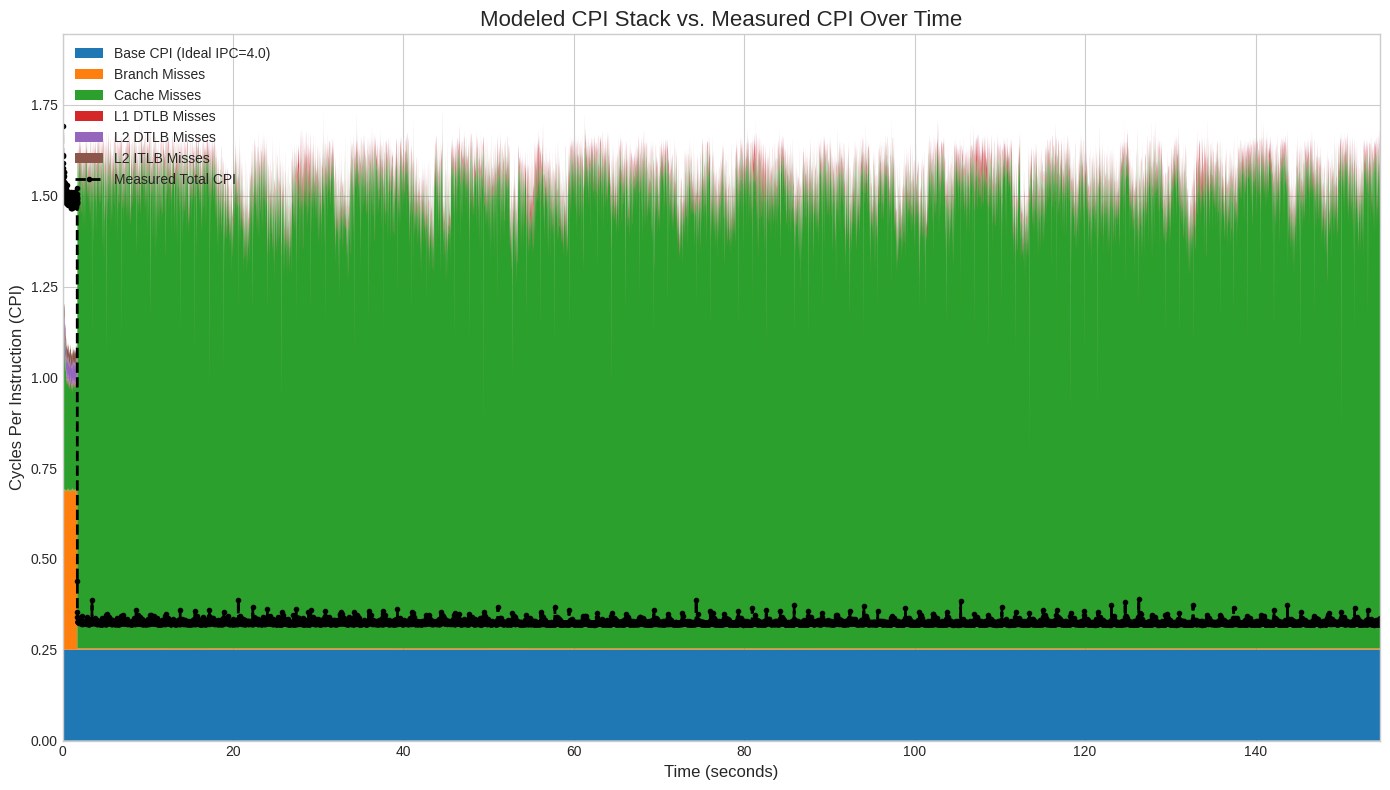

In [ ]:
data_file = '2b_data_lud_new_ext'
plot_cpi_stack_from_file(data_file)

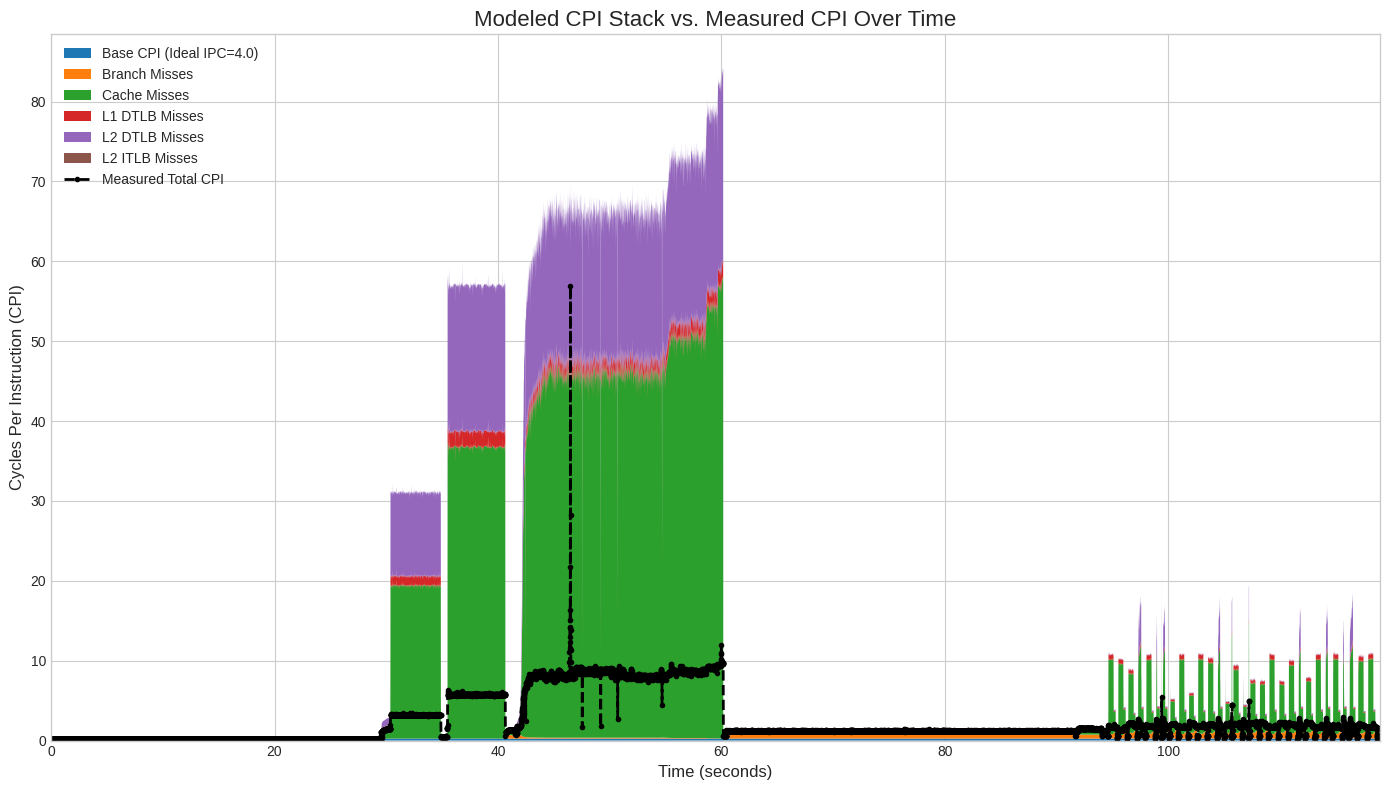

In [ ]:
data_file = '2b_data_new_ext'
plot_cpi_stack_from_file(data_file)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import nnls
from sklearn.metrics import mean_squared_error, r2_score
import sys

def build_cpi_regression_model(filepath):
    """
    Builds a non-negative linear regression model for CPI from performance data.

    Args:
        filepath (str): The path to the input data file.
    """
    # 1. PARSE THE DATA
    data_points = []
    expected_metrics = [
        'instructions', 'cycles', 'branch-misses', 'cache-misses',
        'l1_dtlb_misses', 'l2_dtlb_misses', 'l2_itlb_misses'
    ]

    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
            for i in range(0, len(lines), 7):
                chunk = lines[i:i+7]
                if len(chunk) < 7: continue
                point = {}
                for j, line in enumerate(chunk):
                    parts = line.strip().split()
                    if len(parts) >= 2 and parts[1] == expected_metrics[j]:
                        point[parts[1]] = int(parts[0])
                if len(point) == len(expected_metrics):
                    data_points.append(point)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        sys.exit(1)

    if not data_points:
        print("Error: No valid data points found.")
        sys.exit(1)

    # 2. PREPARE DATA FOR REGRESSION
    cpi_list = []
    predictors_list = []
    predictor_names = [
        'branch_miss_rate', 'cache_miss_rate', 'l1_dtlb_miss_rate',
        'l2_dtlb_miss_rate', 'l2_itlb_miss_rate'
    ]

    for point in data_points:
        instr = point['instructions']
        if instr == 0: continue

        cpi_list.append(point['cycles'] / instr)

        predictors_list.append([
            point['branch-misses'] / instr,
            point['cache-misses'] / instr,
            point['l1_dtlb_misses'] / instr,
            point['l2_dtlb_misses'] / instr,
            point['l2_itlb_misses'] / instr
        ])

    y = np.array(cpi_list)
    X = np.array(predictors_list)

    # Add a constant (for the intercept/base_cpi) to the predictors
    X_with_const = sm.add_constant(X, prepend=True)

    # 3. PERFORM NON-NEGATIVE LINEAR REGRESSION
    # scipy.optimize.nnls finds the non-negative coefficients (x) that minimize ||Ax - b||
    coeffs_nn, _ = nnls(X_with_const, y)

    base_cpi_nn = coeffs_nn[0]
    event_penalties_nn = coeffs_nn[1:]

    # 4. REPORT THE MODEL AND ITS QUALITY METRICS
    print("--- Non-Negative Linear Regression Model ---")
    print("\nThis model finds the best-fit CPI stack with non-negative components.")
    print("\nThe coefficients represent the effective cycle penalty for each miss event.")

    print(f"\nCPI = {base_cpi_nn:.4f} (Base CPI)")
    for i, name in enumerate(predictor_names):
        print(f"      + {event_penalties_nn[i]:.4f} * ({name})")

    # Calculate predictions and metrics for the non-negative model
    y_pred_nn = X_with_const @ coeffs_nn

    n = len(y)  # Number of samples
    p = X.shape[1] # Number of predictors

    rmse_nn = np.sqrt(mean_squared_error(y, y_pred_nn))
    r2_nn = r2_score(y, y_pred_nn)
    adj_r2_nn = 1 - (1 - r2_nn) * (n - 1) / (n - p - 1)

    print("\n--- Model Quality (Non-Negative Model) ---")
    print(f"RMSE: {rmse_nn:.4f}")
    print(f"R-squared: {r2_nn:.4f}")
    print(f"Adjusted R-squared: {adj_r2_nn:.4f}")

    # 5. STATISTICAL SUMMARY FROM STANDARD OLS (for reference)
    print("\n--- Standard OLS Model Summary (for F-statistic & p-value) ---")
    print("NOTE: This is from a standard OLS model without non-negative constraints.")
    ols_model = sm.OLS(y, X_with_const).fit()
    print(ols_model.summary())

    # 6. PLOT RESIDUALS
    residuals_nn = y - y_pred_nn

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(y_pred_nn, residuals_nn, alpha=0.6, edgecolors='w', s=50)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted CPI')
    ax.set_ylabel('Residuals (Actual - Predicted)')
    ax.set_title('Residual Plot for Non-Negative CPI Model')
    plt.tight_layout()
    plt.show()


--- Non-Negative Linear Regression Model ---

This model finds the best-fit CPI stack with non-negative components.

The coefficients represent the effective cycle penalty for each miss event.

CPI = 0.3179 (Base CPI)
      + 0.0000 * (branch_miss_rate)
      + 0.1265 * (cache_miss_rate)
      + 0.0000 * (l1_dtlb_miss_rate)
      + 67.4977 * (l2_dtlb_miss_rate)
      + 2691.2772 * (l2_itlb_miss_rate)

--- Model Quality (Non-Negative Model) ---
RMSE: 0.0045
R-squared: 0.9987
Adjusted R-squared: 0.9987

--- Standard OLS Model Summary (for F-statistic & p-value) ---
NOTE: This is from a standard OLS model without non-negative constraints.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.365e+06
Date:                Sun, 28 Sep 2025   

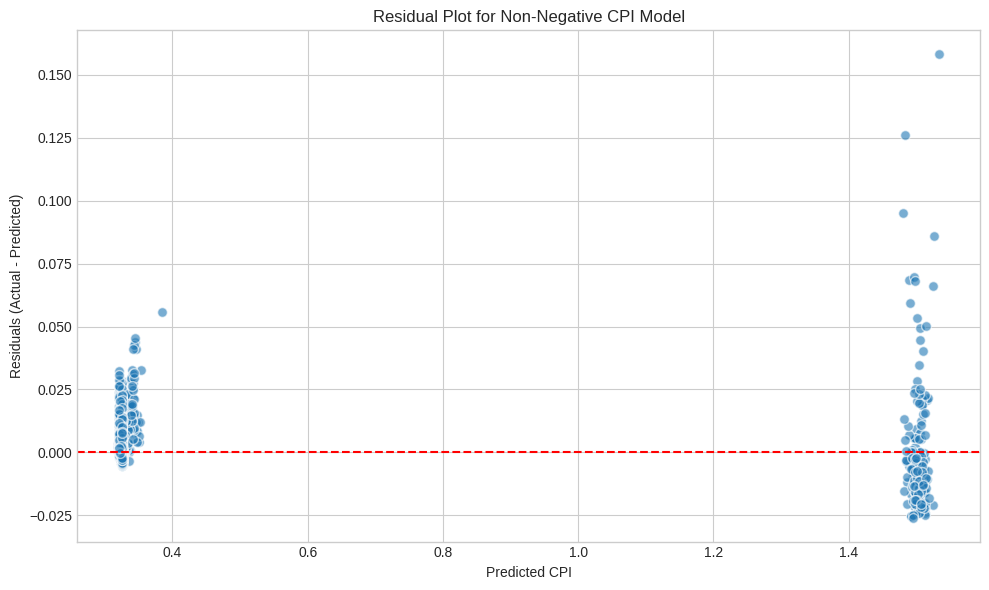

In [ ]:
data_file = '2b_data_lud_new_ext'
build_cpi_regression_model(data_file)

--- Non-Negative Linear Regression Model ---

This model finds the best-fit CPI stack with non-negative components.

The coefficients represent the effective cycle penalty for each miss event.

CPI = 0.1320 (Base CPI)
      + 24.2794 * (branch_miss_rate)
      + 15.2414 * (cache_miss_rate)
      + 0.0000 * (l1_dtlb_miss_rate)
      + 2.8736 * (l2_dtlb_miss_rate)
      + 2183.7808 * (l2_itlb_miss_rate)

--- Model Quality (Non-Negative Model) ---
RMSE: 0.5959
R-squared: 0.9569
Adjusted R-squared: 0.9569

--- Standard OLS Model Summary (for F-statistic & p-value) ---
NOTE: This is from a standard OLS model without non-negative constraints.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 5.804e+04
Date:                Sun, 28 Sep 2025  

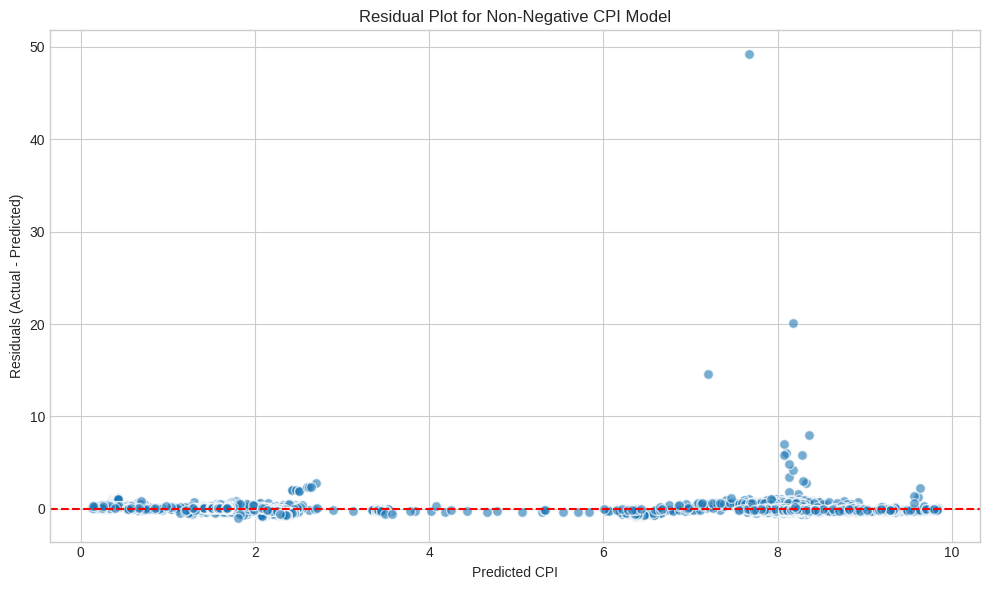

In [ ]:
data_file = '2b_data_new_ext'
build_cpi_regression_model(data_file)